In [1]:
import os
import numpy as np
import pandas as pd
import scipy
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import train_test_split, KFold
from mllib.model import KerasSurrogate
from tensorflow import keras

In [2]:
class AdjustedRSquaredSeparated(tf.keras.losses.Loss):
    '''
    Calculates the adjusted R^2 value for each predicted quantity separately.

    For more details, see:
    https://www.analyticsvidhya.com/blog/2020/07/difference-between-r-squared-and-adjusted-r-squared/
    '''
    def __init__(self, batch_size, number_of_input):
        '''
        Parameters
        ==========
        batch_size: int
            Number of samples in a batch,
            i. e. number of rows of a batch of the X matrix.
        number_of_input: int
            Number of independent variables (=columns) in the problem,
            i. e. number of columns of the X matrix.
        '''
        super().__init__(name='adjusted_r2')
        self._n = batch_size
        self._n_in = number_of_input

    def call(self, y_true, y_pred):
        r2 = RSquaredSeparated().call(y_true, y_pred)

        adjusted_r2 = 1. - (1. - r2) * (self._n - 1.) / (self._n - self._n_in - 1.)

        return adjusted_r2

    @classmethod
    def from_config(cls, config):
        return AdjustedRSquaredSeparated(config['n'], config['n_in'])

    def get_config(self):
        return {
            'n': self._n,
            'n_in': self._n_in,
        }

In [3]:
class RSquaredSeparated(tf.keras.losses.Loss):
    '''
    Calculates the R^2 value for each predicted quantity separately.

    For more details, see:
    https://www.analyticsvidhya.com/blog/2020/07/difference-between-r-squared-and-adjusted-r-squared/
    '''
    def __init__(self):
        super().__init__(name='r2')

    def call(self, y_true, y_pred):
        mean_true = tf.math.reduce_mean(y_true, axis=0)

        total_sum_of_squares = tf.math.reduce_sum(tf.math.squared_difference(y_true, mean_true),
                                                  axis=0)
        
        residual_sum_of_squares = tf.math.reduce_sum(tf.math.squared_difference(y_true, y_pred),
                                                     axis=0)
        r2 = 1. - residual_sum_of_squares / total_sum_of_squares

        return r2

In [4]:
class AdjustedRSquared(tf.keras.losses.Loss):
    '''
    For more details, see:
    https://www.analyticsvidhya.com/blog/2020/07/difference-between-r-squared-and-adjusted-r-squared/
    '''
    def __init__(self, batch_size, number_of_input):
        '''
        Parameters
        ==========
        batch_size: int
            Number of samples in a batch,
            i. e. number of rows of a batch of the X matrix.
        number_of_input: int
            Number of independent variables (=columns) in the problem,
            i. e. number of columns of the X matrix.
        '''
        super().__init__(name='adjusted_r2')
        self._n = batch_size
        self._n_in = number_of_input

    def call(self, y_true, y_pred):
        r2 = RSquared().call(y_true, y_pred)

        adjusted_r2 = 1. - (1. - r2) * (self._n - 1.) / (self._n - self._n_in - 1.)
        adjusted_r2 = tf.math.reduce_mean(adjusted_r2)

        return adjusted_r2

    @classmethod
    def from_config(cls, config):
        return AdjustedRSquared(config['n'], config['n_in'])

    def get_config(self):
        return {
            'n': self._n,
            'n_in': self._n_in,
        }

In [5]:
#wMAPE

def wmape(actual, pred):
    wMAPE = np.sum(np.abs(actual-pred))/np.sum(np.abs(actual))*100
    return wMAPE

In [6]:
seed = 1234
tf.random.set_seed(seed)
np.random.seed(seed)

# Include test data and Models

In [7]:
test_datafile_fw = '/data/project/general/aerosolretriev/aerosol_data/dataset_12_2022/preprocessed_new/data_all_test_fw1.h5'
test_datafile_iv = '/data/project/general/aerosolretriev/aerosol_data/dataset_12_2022/preprocessed_new/data_all_test_iv1.h5'



In [8]:
model_name_fw = 'forward_model/surrogate_model'
model_name_iv = 'forward_model/surrogate_model'

In [9]:
model_dir_fw = '/data/project/general/aerosolretriev/aerosol_results_december_2022/results_01_12_2022/forward_models_fw/forward_model_fw10_s1/models'

model_dir_iv = '/data/project/general/aerosolretriev/aerosol_results_december_2022/results_01_12_2022/forward_models_iv/forward_model_iv10_s1/models'




In [10]:
# Resulting plots will be stored in the fw model directory
plot_dir = model_dir_fw +'/plots/model_1'
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)
plot_dir

'/data/project/general/aerosolretriev/aerosol_results_december_2022/results_01_12_2022/forward_models_fw/forward_model_fw10_s1/models/plots/model_1'

# Load the model and the data

In [11]:
custom_objects = {
    'AdjustedRSquared': AdjustedRSquared,
}

kwargs = {
    'custom_objects': custom_objects,
    'compile': False,
}

surr_fw = KerasSurrogate.load(model_dir_fw, model_name_fw, model_kwargs=kwargs)
surr_iv = KerasSurrogate.load(model_dir_iv, model_name_iv, model_kwargs=kwargs)


In [12]:
dvar_test = pd.read_hdf(test_datafile_iv,key = 'dvar')
qoi_test = pd.read_hdf(test_datafile_iv,key = 'qoi')

# I just include the test_datafile_iv, because it should be the same as test_datafile_fw, just dvar and qoi are switched
# In the test datafile dvar are preprocessed already with:
# log(dvar['Vtot'],dvar['RmedianV'],dvar['GSD']-1, dvar['n']-1.33,dvar['k'])
# qoi are preprocessed with log(qoi[F11])

dvar_test_preprocessed = dvar_test.copy()
qoi_test_preprocessed = qoi_test.copy()


In [13]:
#dvar_test1 = pd.read_hdf(test_datafile_fw,key = 'dvar')
#qoi_test1 = pd.read_hdf(test_datafile_fw,key = 'qoi')


# Predict aerosol properties from phase functions

In [14]:
dvar_pred = surr_fw.predict(qoi_test_preprocessed)
dvar_pred = pd.DataFrame(data=dvar_pred, columns=dvar_test.columns)

In [15]:
dvar_pred = np.exp(dvar_pred)
dvar_pred['GSD']=dvar_pred['GSD']+1
dvar_pred['n']= dvar_pred['n']+1.33

dvar_test = np.exp(dvar_test)
dvar_test['GSD']=dvar_test['GSD']+1
dvar_test['n']=dvar_test['n']+1.33

## 1.calculate metrics

In [16]:
fw_error_df = pd.DataFrame(columns = dvar_test.columns)
fw_error_df


Empty DataFrame
Columns: [Vtot, RmedianV, GSD, n, k]
Index: []

In [17]:
# R2 value
metric = AdjustedRSquaredSeparated(dvar_test.shape[0], dvar_test.shape[1])

r2_adj_fw = metric.call(dvar_test.values, dvar_pred.values).numpy()
r2_adj_fw = pd.Series(data=r2_adj_fw, index=dvar_test.columns)
r2_adj_fw = np.round(r2_adj_fw, decimals=2)
r2_adj_fw = pd.DataFrame(r2_adj_fw).T
r2_adj_fw

Vtot  RmedianV  GSD     n     k
0   1.0       1.0  1.0  0.99  0.99

In [18]:
fw_error_df.loc['r2']= [r2_adj_fw['Vtot'].values[0], r2_adj_fw['RmedianV'].values[0],r2_adj_fw['GSD'].values[0],r2_adj_fw['n'].values[0],r2_adj_fw['k'].values[0]]
fw_error_df


Vtot  RmedianV  GSD     n     k
r2   1.0       1.0  1.0  0.99  0.99

In [19]:
# absolute error
abs_error_fw = np.abs(dvar_test-dvar_pred)
abs_error_fw = pd.DataFrame(abs_error_fw, columns=dvar_test.columns).abs()
abs_error_fw.reset_index(drop=True, inplace=True)
abs_error_fw

Vtot    RmedianV       GSD         n         k
0       0.059799    1.189285  0.001426  0.012231  0.072865
1       0.481506  136.570013  0.066603  0.047363  0.070721
2       1.288854    2.841568  0.007869  0.117914  0.088950
3       0.670935    1.298846  0.015073  0.004090  0.074251
4      14.602303    1.850887  0.000112  0.018528  0.013556
...          ...         ...       ...       ...       ...
19464  51.166074    0.327476  0.002130  0.014897  0.011407
19465   0.042736    2.316568  0.000885  0.006677  0.063760
19466   0.073135    1.266327  0.015903  0.059043  0.059669
19467  18.666943   11.125930  0.006652  0.044774  0.033939
19468   1.965517    2.374156  0.023338  0.020791  0.016320

[19469 rows x 5 columns]

In [20]:
abs_error_table_fw = np.round(abs_error_fw.quantile([0.5, 0.75, 0.9, 0.95, 0.99]).rename(index={
    0.5: '50%',
    0.75: '75%',
    0.9: '90%',
    0.95: '95%',
    0.99: '99%',
}), decimals=2)
abs_error_table_fw

Vtot  RmedianV   GSD     n     k
50%    1.17      7.34  0.01  0.03  0.03
75%   10.16     37.25  0.03  0.05  0.05
90%   44.23    104.45  0.04  0.08  0.08
95%   82.88    162.56  0.06  0.10  0.11
99%  203.78    292.77  0.09  0.18  0.18

In [21]:
fw_error_df.loc['abs error 90%'] = abs_error_table_fw.loc['90%']

fw_error_df.loc['abs error 95%'] = abs_error_table_fw.loc['95%']


In [22]:
rel_error_fw = np.abs(dvar_test - dvar_pred) / dvar_test * 100.
rel_error_fw = pd.DataFrame(rel_error_fw, columns=dvar_test.columns).abs()
rel_error_fw.reset_index(drop=True, inplace=True)
rel_error_fw

Vtot  RmedianV       GSD         n         k
0      1.207327  0.266000  0.084506  0.466321  9.661215
1      4.886638  4.624615  2.527251  2.268355  3.956617
2      4.652901  1.116146  0.753626  4.046894  8.077614
3      1.368934  0.250044  0.689658  0.172990  3.611986
4      3.307975  1.842208  0.005071  0.642530  0.683445
...         ...       ...       ...       ...       ...
19464  1.762591  0.133763  0.103951  1.021027  2.433781
19465  1.126631  1.133637  0.073392  0.427457  5.893652
19466  0.813451  0.239799  0.815664  2.195356  3.184072
19467  0.788612  1.426233  0.260263  1.595189  6.307456
19468  2.328766  1.407886  0.904600  0.811093  1.478101

[19469 rows x 5 columns]

In [23]:
rel_error_table_fw = np.round(rel_error_fw.quantile([0.5, 0.75, 0.9, 0.95, 0.99]).rename(index={
    0.5: '50%',
    0.75: '75%',
    0.9: '90%',
    0.95: '95%',
    0.99: '99%',
}), decimals=2)
rel_error_table_fw

Vtot  RmedianV   GSD     n      k
50%   2.06      1.40  0.74  1.30   2.98
75%   3.64      2.69  1.31  2.23   5.61
90%   5.65      4.32  1.99  3.27  10.05
95%   7.14      5.44  2.56  4.14  14.71
99%  12.32      8.47  4.26  7.09  40.15

In [24]:
fw_error_df.loc['rel error 90%'] = rel_error_table_fw.loc['90%']

fw_error_df.loc['rel error 95%'] = rel_error_table_fw.loc['95%']
                                            

In [25]:
wMAPE_fw = wmape(dvar_test, dvar_pred)
wMAPE_fw = pd.DataFrame(wMAPE_fw).T
wMAPE_fw=np.round(wMAPE_fw, decimals =2)
wMAPE_fw

Vtot  RmedianV  GSD     n     k
0  2.75      2.81  1.0  1.72  3.39

In [26]:
fw_error_df.loc['wmape'] = [wMAPE_fw['Vtot'].values[0],wMAPE_fw['RmedianV'].values[0],wMAPE_fw['GSD'].values[0],wMAPE_fw['n'].values[0],wMAPE_fw['k'].values[0]]
fw_error_df

Vtot  RmedianV   GSD     n      k
r2              1.00      1.00  1.00  0.99   0.99
abs error 90%  44.23    104.45  0.04  0.08   0.08
abs error 95%  82.88    162.56  0.06  0.10   0.11
rel error 90%   5.65      4.32  1.99  3.27  10.05
rel error 95%   7.14      5.44  2.56  4.14  14.71
wmape           2.75      2.81  1.00  1.72   3.39

In [27]:
fw_error_df.to_csv(f'{plot_dir}/fw_error_df.csv')

## 2. plots

In [28]:
def lognormal(D_array, D_median, GSD, Ntot):  # dn/dD
    n = (Ntot/(np.sqrt(2*np.pi)*(np.log(GSD)))/D_array) * np.exp(-(np.log(D_array)-np.log(D_median))**2/(2*(np.log(GSD)**2)))   # nm-1 * cm-3
    return n

In [29]:
dvar_test['DmedianV']=dvar_test['RmedianV']*2*1e-3 #[um]
dvar_test['DmedianN']=(np.exp(np.log(dvar_test['DmedianV']) - (3*np.log(dvar_test['GSD'])**2))) *1e3   #[nm]
dvar_test['Ntot'] = 6 / np.pi * dvar_test['Vtot']*1e9 / (np.exp((3*np.log(dvar_test['DmedianN'])) + (4.5*np.log(dvar_test['GSD'])**2))) # [cm^-3]
 

In [30]:
dvar_pred['DmedianV']=dvar_pred['RmedianV']*2*1e-3 #[um]
dvar_pred['DmedianN']=(np.exp(np.log(dvar_pred['DmedianV']) - (3*np.log(dvar_pred['GSD'])**2))) *1e3   #[nm]
dvar_pred['Ntot'] = 6 / np.pi * dvar_pred['Vtot']*1e9 / (np.exp((3*np.log(dvar_pred['DmedianN'])) + (4.5*np.log(dvar_pred['GSD'])**2))) # [cm^-3]


In [31]:
D_array = np.logspace(1, 4.5, 200)  # [nm]
presentation_plot_index = [100,200,300,400,500]

In [32]:
fig, ax = plt.subplots(figsize = (10,10))

colors_blue = ['lightskyblue','deepskyblue','dodgerblue','blue','darkblue']
colors_red = ['orange','coral','orangered','red','firebrick','darkred']

j = 0
for i  in presentation_plot_index:
    
    pdf1 = lognormal(D_array, dvar_test['DmedianN'].loc[i], dvar_test['GSD'].loc[i], dvar_test['Ntot'].loc[i])
    pdf2 = lognormal(D_array, dvar_pred['DmedianN'].loc[i], dvar_pred['GSD'].loc[i], dvar_pred['Ntot'].loc[i])
    
    ax.plot(D_array, pdf1*4/3.*np.pi*D_array**3., '*', color = colors_red[j], label = 'true_'+str(i))
    
    ax.plot(D_array, pdf2*4/3.*np.pi*D_array**3., color = colors_blue[j], label = 'pred_'+str(i))
    


    ax.legend(fontsize = 16)   
    j = j+1
ax.set_xlabel('Particle Radius [$\mu$m]',fontsize = 25)
ax.set_ylabel('Concentration ',fontsize = 25)
ax.tick_params(labelsize = 16)    
ax.set_title( 'Comparison Simulation and Prediction',fontsize = 25)
fig.align_labels()

plt.xscale('log')
#plt.yscale('log')
fig.tight_layout() 
fig.savefig(f'{plot_dir}/size_distribution_true_pred.jpg')

## 3. plot the biggest error 

In [33]:
from scipy.interpolate import griddata
from mpl_toolkits.axes_grid1 import make_axes_locatable


In [34]:
testGSD1 = rel_error_fw['GSD'].values
testR = rel_error_fw['RmedianV'].values
testn = rel_error_fw['n'].values
testk = rel_error_fw['k'].values
testVtot = rel_error_fw['Vtot'].values
testGSD2 = np.log(dvar_test['RmedianV'].values)
testGSD3 = np.log(dvar_test['GSD'].values)


In [35]:
grid_x, grid_y = np.mgrid[100:5001:1, 1.01:3.1:0.01]

grid_x = np.log(grid_x)
grid_y = np.log(grid_y)
grid_GSD = griddata((testGSD2,testGSD3), testGSD1, (grid_x, grid_y), method='nearest')
grid_R = griddata((testGSD2,testGSD3), testR, (grid_x, grid_y), method='nearest')
grid_Vtot = griddata((testGSD2,testGSD3), testVtot, (grid_x, grid_y), method='nearest')
grid_n = griddata((testGSD2,testGSD3), testn, (grid_x, grid_y), method='nearest')
grid_k = griddata((testGSD2,testGSD3), testk, (grid_x, grid_y), method='nearest')


In [36]:
fig, ax = plt.subplots()
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)

im = ax.imshow(grid_GSD.T, extent=(np.log(100),np.log(5000),np.log(1.01),np.log(3.1)),vmin=0, vmax=5,aspect = 'auto',cmap = 'Blues')

ax.set_xlabel('GSD')
ax.set_ylabel('RmedianV')
ax.set_title('relative error GSD')
fig.colorbar(im, cax=cax, orientation='vertical')
plt.show()
fig.savefig(f'{plot_dir}/rel_errGSD_GSD_R.jpg')

In [37]:
fig, ax = plt.subplots()
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)

im = ax.imshow(grid_R.T, extent=(np.log(100),np.log(5000),np.log(1.01),np.log(3.1)),vmin=0, vmax=5,aspect = 'auto',cmap = 'Blues')
ax.set_xlabel('GSD')
ax.set_ylabel('RmedianV')
ax.set_title('relative error RmedianV')

fig.colorbar(im, cax=cax, orientation='vertical')
plt.show()
fig.savefig(f'{plot_dir}/rel_errR_GSD_R.jpg')

In [38]:
fig, ax = plt.subplots()
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)

im = ax.imshow(grid_n.T, extent=(np.log(100),np.log(5000),np.log(1.01),np.log(3.1)),vmin=0, vmax=5,aspect = 'auto',cmap = 'Blues')

ax.set_xlabel('GSD')
ax.set_ylabel('RmedianV')
ax.set_title('relative error n')

fig.colorbar(im, cax=cax, orientation='vertical')
plt.show()
fig.savefig(f'{plot_dir}/rel_errn_GSD_R.jpg')

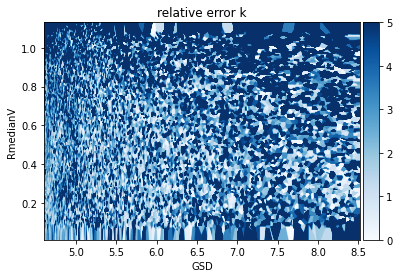

In [39]:
fig, ax = plt.subplots()
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)

im = ax.imshow(grid_k.T, extent=(np.log(100),np.log(5000),np.log(1.01),np.log(3.1)),vmin=0, vmax=5,aspect = 'auto',cmap = 'Blues')
ax.set_xlabel('GSD')
ax.set_ylabel('RmedianV')
ax.set_title('relative error k')

fig.colorbar(im, cax=cax, orientation='vertical')
plt.show()
fig.savefig(f'{plot_dir}/rel_errk_GSD_R.jpg')

In [40]:
fig, ax = plt.subplots()
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)

im = ax.imshow(grid_Vtot.T, extent=(np.log(100),np.log(5000),np.log(1.01),np.log(3.1)),vmin=0, vmax=5,aspect = 'auto',cmap = 'Blues')

ax.set_xlabel('GSD')
ax.set_ylabel('RmedianV')
ax.set_title('relative error Vtot')

fig.colorbar(im, cax=cax, orientation='vertical')
plt.show()
fig.savefig(f'{plot_dir}/rel_errVtot_GSD_R.jpg')

# Predict phase functions from aerosol properties

In [41]:
qoi_pred = surr_iv.predict(dvar_test_preprocessed)
qoi_pred = pd.DataFrame(data=qoi_pred, columns=qoi_test.columns)

In [42]:
F11_columns = [x for x in qoi_test.columns if 'F11' in x]
PPF_columns = [x for x in qoi_test.columns if 'PPF' in x]

In [43]:
qoi_test[F11_columns] = np.exp(qoi_test[F11_columns])
qoi_pred[F11_columns] = np.exp(qoi_pred[F11_columns])


In [44]:
## 1. calculate metrics

In [45]:
metric = RSquaredSeparated()
r2_adj_iv = metric.call(qoi_test.values, qoi_pred.values).numpy()
r2_adj_iv = pd.Series(data=r2_adj_iv, index=qoi_test.columns)
r2_adj_iv = np.round(r2_adj_iv, decimals=2)
r2_adj_iv = pd.DataFrame(r2_adj_iv).T
print('Forward model: ','R2_min = ', min(r2_adj_iv.min()),';  R2_max = ', max(r2_adj_iv.max()))
r2_adj_iv

Forward model:  R2_min =  0.94 ;  R2_max =  1.0


F11_10  F11_11  F11_12  F11_13  F11_14  F11_15  F11_16  F11_17  F11_18  \
0     1.0     1.0     1.0     1.0     1.0     1.0     1.0     1.0     1.0   

   F11_19  ...  PPF_161  PPF_162  PPF_163  PPF_164  PPF_165  PPF_166  PPF_167  \
0     1.0  ...     0.97     0.96     0.96     0.95     0.95     0.95     0.94   

   PPF_168  PPF_169  PPF_170  
0     0.94     0.94     0.94  

[1 rows x 304 columns]

In [46]:
iv_error_df = pd.DataFrame(columns = ['F11','PPF'])
iv_error_df.loc['r2']= [np.mean(r2_adj_iv[F11_columns].mean()),np.mean(r2_adj_iv[PPF_columns].mean())]
iv_error_df

F11       PPF
r2  1.0  0.994013

In [47]:
r2_adj_iv.values

array([[1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  ,
        1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  ,
        1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  ,
        1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  ,
        1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  ,
        1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  ,
        1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  ,
        1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  ,
        1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  ,
        1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  ,
        1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  ,
        1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  ,
        1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  ,
        1.  , 1.  , 1.  , 1.  , 1.  , 

In [48]:
abs_error_iv = np.abs(qoi_pred - qoi_test)
abs_error_iv

F11_10      F11_11      F11_12      F11_13      F11_14      F11_15  \
0        0.525106    0.408714    0.322547    0.243609    0.167377    0.103325   
1        0.015660    0.011149    0.010655    0.000390    0.005130    0.008761   
2        6.652235    4.297868    1.125346    1.697989    3.615286    4.019317   
3        3.719066    4.285243    4.627201    4.567807    4.024171    3.508321   
4       17.413003   19.976317   21.719870   20.798353   18.401455   16.618683   
...           ...         ...         ...         ...         ...         ...   
19464  265.962897  260.147069  249.002473  220.065029  172.361593  149.018392   
19465    0.047028    0.073039    0.019628    0.031453    0.079987    0.150642   
19466    0.742629    0.704123    0.729239    0.674082    0.551413    0.428934   
19467   44.698049   42.354414   54.435461   61.391585   56.555155   47.292523   
19468    4.453734    4.257801    4.162281    3.722364    3.234251    2.829031   

           F11_16      F11_17      F11_18     F11_19  ...   PPF_161  \
0        0.064166    0.034785    0.008917   0.002958  ...  0.000332   
1        0.004187    0.000956    0.000462   0.000362  ...  0.000013   
2        3.646832    3.164565    2.536314   1.591985  ...  0.010200   
3        2.862952    2.272565    1.709325   1.237389  ...  0.001024   
4       14.970439   13.188401   10.945333   8.439780  ...  0.001052   
...           ...         ...         ...        ...  ...       ...   
19464  130.406030  120.177106  104.035423  92.051911  ...  0.000703   
19465    0.188975    0.207727    0.236503   0.216473  ...  0.003499   
19466    0.333893    0.262956    0.208134   0.169566  ...  0.000370   
19467   36.398131   30.637183   24.001026  19.077928  ...  0.000141   
19468    2.588976    2.400998    2.071954   1.799937  ...  0.001380   

            PPF_162   PPF_163   PPF_164   PPF_165   PPF_166   PPF_167  \
0      1.685298e-04  0.000017  0.000154  0.000268  0.000307  0.000365   
1      2.403023e-07  0.000080  0.000038  0.000087  0.000183  0.000359   
2      9.678127e-03  0.009506  0.009391  0.009220  0.008862  0.009032   
3      1.112653e-03  0.001263  0.001207  0.001097  0.000912  0.000569   
4      1.107974e-03  0.001335  0.001405  0.001404  0.001284  0.000997   
...             ...       ...       ...       ...       ...       ...   
19464  6.997197e-04  0.000860  0.000907  0.000914  0.000876  0.000826   
19465  3.870882e-03  0.003614  0.003243  0.002805  0.002139  0.001832   
19466  4.034047e-04  0.000538  0.000549  0.000527  0.000441  0.000309   
19467  2.847018e-04  0.000349  0.000459  0.000588  0.000678  0.000697   
19468  1.475585e-03  0.001588  0.001564  0.001440  0.001259  0.001033   

        PPF_168   PPF_169   PPF_170  
0      0.000329  0.000133  0.000144  
1      0.000550  0.000758  0.000971  
2      0.008839  0.009209  0.009353  
3      0.000183  0.000323  0.000767  
4      0.000696  0.000216  0.000263  
...         ...       ...       ...  
19464  0.000557  0.000029  0.000580  
19465  0.001144  0.000255  0.000494  
19466  0.000108  0.000240  0.000586  
19467  0.000775  0.000826  0.000888  
19468  0.000700  0.000231  0.000235  

[19469 rows x 304 columns]

In [49]:
abs_error_table_iv =  np.round(abs_error_iv.quantile([0.5, 0.75, 0.9, 0.95, 0.99]).rename(index={
    0.5: '50%',
    0.75: '75%',
    0.9: '90%',
    0.95: '95%',
    0.99: '99%',
}), decimals=2)
abs_error_table_iv

F11_10  F11_11  F11_12  F11_13  F11_14  F11_15  F11_16  F11_17  F11_18  \
50%    1.60    1.30    1.16    1.03    0.86    0.74    0.62    0.53    0.42   
75%   15.02   12.34   11.57   10.38    8.52    7.21    6.08    5.38    4.47   
90%   72.57   62.05   58.96   53.78   45.21   38.81   33.74   31.01   26.25   
95%  146.17  126.61  118.28  108.31   92.79   80.39   70.82   65.11   55.56   
99%  374.26  309.85  281.44  268.48  234.92  208.84  191.37  174.64  157.76   

     F11_19  ...  PPF_161  PPF_162  PPF_163  PPF_164  PPF_165  PPF_166  \
50%    0.36  ...     0.00     0.00     0.00     0.00     0.00     0.00   
75%    3.77  ...     0.00     0.00     0.00     0.00     0.00     0.00   
90%   22.50  ...     0.00     0.00     0.00     0.00     0.00     0.00   
95%   49.93  ...     0.01     0.01     0.01     0.00     0.00     0.00   
99%  137.54  ...     0.02     0.02     0.02     0.02     0.02     0.01   

     PPF_167  PPF_168  PPF_169  PPF_170  
50%     0.00     0.00     0.00     0.00  
75%     0.00     0.00     0.00     0.00  
90%     0.00     0.00     0.00     0.00  
95%     0.00     0.00     0.00     0.00  
99%     0.01     0.01     0.01     0.01  

[5 rows x 304 columns]

In [50]:
iv_error_df.loc['abs error 90%']=[abs_error_table_iv[F11_columns].loc['90%'].max(), abs_error_table_iv[PPF_columns].loc['90%'].max()]
iv_error_df.loc['abs error 95%']=[abs_error_table_iv[F11_columns].loc['95%'].max(), abs_error_table_iv[PPF_columns].loc['95%'].max()]


In [51]:
rel_error_iv = abs_error_iv / qoi_test * 100.
rel_error_iv = pd.DataFrame(rel_error_iv, columns=qoi_test.columns).abs()
rel_error_iv

F11_10    F11_11    F11_12    F11_13    F11_14    F11_15    F11_16  \
0      2.631704  2.235323  1.930205  1.598482  1.206194  0.818763  0.559565   
1      0.194878  0.172293  0.201578  0.008917  0.140219  0.283289  0.158680   
2      6.478357  4.281470  1.149235  1.781480  3.905292  4.479902  4.203182   
3      2.120744  2.714065  3.248426  3.546906  3.448745  3.311108  2.969097   
4      1.810712  2.118550  2.351431  2.300460  2.080976  1.922749  1.773049   
...         ...       ...       ...       ...       ...       ...       ...   
19464  3.388995  3.504981  3.551972  3.327234  2.764465  2.537122  2.358068   
19465  0.391760  0.618943  0.169479  0.277155  0.720430  1.389086  1.786815   
19466  2.223166  2.347212  2.705260  2.780144  2.525300  2.178144  1.877056   
19467  0.702158  0.756744  1.100288  1.396916  1.442117  1.345749  1.151326   
19468  1.889463  1.888582  1.930362  1.804913  1.639385  1.498744  1.433153   

         F11_17    F11_18    F11_19  ...    PPF_161    PPF_162    PPF_163  \
0      0.334010  0.094296  0.034454  ...   1.007772   0.553618   0.060888   
1      0.042111  0.023480  0.021036  ...   0.071738   0.001412   0.514205   
2      3.779748  3.146134  2.055303  ...  30.495210  28.796690  28.752712   
3      2.584137  2.126550  1.680675  ...   2.981165   3.509894   4.346304   
4      1.599773  1.360406  1.075261  ...   2.407218   2.816542   3.795660   
...         ...       ...       ...  ...        ...        ...        ...   
19464  2.308917  2.124315  1.998043  ...   1.138690   1.253210   1.714114   
19465  2.017172  2.362301  2.227536  ...   5.986228   7.288419   7.540013   
19466  1.633758  1.426619  1.279846  ...   1.222289   1.436215   2.076016   
19467  1.073332  0.928109  0.811694  ...   0.419139   0.926125   1.255149   
19468  1.388381  1.251165  1.134661  ...   2.773215   3.288172   3.947377   

         PPF_164    PPF_165    PPF_166    PPF_167    PPF_168    PPF_169  \
0       0.604240   1.166949   1.498191   2.014655   2.083749   0.977048   
1       0.273498   0.686495   1.621345   3.595358   6.288190  10.026084   
2      29.441725  30.515601  31.524639  35.170140  38.387629  45.521626   
3       4.564296   4.595343   4.273784   3.013361   1.110344   2.277439   
4       4.497514   5.102999   5.342512   4.804754   3.928562   1.446937   
...          ...        ...        ...        ...        ...        ...   
19464   2.026475   2.307153   2.521219   2.737407   2.153794   0.134517   
19465   7.554532   7.358574   6.380609   6.282012   4.566198   1.201963   
19466   2.312942   2.446750   2.275780   1.791181   0.710378   1.831787   
19467   1.834949   2.633399   3.440660   4.042652   5.206215   6.525395   
19468   4.367450   4.556589   4.553830   4.313235   3.419372   1.340509   

         PPF_170  
0       1.258694  
1      15.102314  
2      53.801664  
3       6.398989  
4       2.130405  
...          ...  
19464   3.192584  
19465   2.796884  
19466   5.272299  
19467   8.380474  
19468   1.637738  

[19469 rows x 304 columns]

In [52]:
rel_error_table_iv = np.round(rel_error_iv.quantile([0.5, 0.75, 0.9, 0.95, 0.99]).rename(index={
    0.5: '50%',
    0.75: '75%',
    0.9: '90%',
    0.95: '95%',
    0.99: '99%',
}), decimals=2)
rel_error_table_iv

F11_10  F11_11  F11_12  F11_13  F11_14  F11_15  F11_16  F11_17  F11_18  \
50%    1.62    1.52    1.56    1.57    1.49    1.42    1.33    1.26    1.16   
75%    2.62    2.34    2.32    2.32    2.22    2.12    1.99    1.92    1.79   
90%    4.07    3.43    3.29    3.24    3.15    3.02    2.87    2.77    2.62   
95%    5.56    4.50    4.26    4.23    4.26    4.14    3.97    3.91    3.74   
99%   10.97    9.81    9.29    9.39    9.33    9.18    9.39    9.55    9.48   

     F11_19  ...  PPF_161  PPF_162  PPF_163  PPF_164  PPF_165  PPF_166  \
50%    1.09  ...     2.94     3.41     4.17     4.61     4.90     5.01   
75%    1.72  ...     5.12     5.76     6.82     7.49     7.99     8.28   
90%    2.56  ...     9.17    10.08    11.40    12.50    13.52    14.56   
95%    3.67  ...    15.46    16.08    17.42    19.18    20.86    22.19   
99%    9.79  ...    67.39    66.02    61.43    63.59    63.11    66.49   

     PPF_167  PPF_168  PPF_169  PPF_170  
50%     4.86     4.44     3.82     4.99  
75%     8.32     8.10     8.23    11.26  
90%    15.52    16.18    17.63    22.97  
95%    23.62    25.54    28.56    35.64  
99%    72.69    77.21    88.26   101.13  

[5 rows x 304 columns]

In [53]:
iv_error_df.loc['rel error 90%']=[rel_error_table_iv[F11_columns].loc['90%'].max(), rel_error_table_iv[PPF_columns].loc['90%'].max()]
iv_error_df.loc['rel error 95%']=[rel_error_table_iv[F11_columns].loc['95%'].max(), rel_error_table_iv[PPF_columns].loc['95%'].max()]


In [54]:

abs_error_table_F11 = abs_error_table_iv[F11_columns]
print('Absolute error F11')
print(abs_error_table_F11.max(axis = 1))
abs_error_table_PPF = abs_error_table_iv[PPF_columns]
print('Absolute error PPF')
print(abs_error_table_PPF.max(axis = 1))
rel_error_table_F11 = rel_error_table_iv[F11_columns]
print('Relative error F11')
print(rel_error_table_F11.max(axis = 1))
rel_error_table_PPF = rel_error_table_iv[PPF_columns]
print('Relative error PPF')
print(rel_error_table_PPF.max(axis = 1))


Absolute error F11
50%      1.60
75%     15.02
90%     72.57
95%    146.17
99%    374.26
dtype: float64
Absolute error PPF
50%    0.00
75%    0.00
90%    0.01
95%    0.01
99%    0.03
dtype: float64
Relative error F11
50%     1.62
75%     2.62
90%     4.07
95%     5.56
99%    10.97
dtype: float64
Relative error PPF
50%      5.01
75%     11.26
90%     22.97
95%     35.64
99%    198.23
dtype: float64


In [55]:
wMAPE_qoi = wmape(qoi_test, qoi_pred)
wMAPE_qoi = pd.DataFrame(wMAPE_qoi).T
np.round(wMAPE_qoi, decimals =2)

F11_10  F11_11  F11_12  F11_13  F11_14  F11_15  F11_16  F11_17  F11_18  \
0    2.08    1.92    1.94    1.93    1.82    1.72    1.64    1.62    1.51   

   F11_19  ...  PPF_161  PPF_162  PPF_163  PPF_164  PPF_165  PPF_166  PPF_167  \
0    1.44  ...     4.93     5.39     6.07     6.63     7.07     7.42     7.67   

   PPF_168  PPF_169  PPF_170  
0     7.75      8.0     9.64  

[1 rows x 304 columns]

In [56]:
iv_error_df.loc['wmape']=[wMAPE_qoi[F11_columns].mean().mean(),wMAPE_qoi[PPF_columns].mean().mean()]
iv_error_df

F11        PPF
r2               1.000000   0.994013
abs error 90%   72.570000   0.010000
abs error 95%  146.170000   0.010000
rel error 90%    4.070000  22.970000
rel error 95%    5.560000  35.640000
wmape            1.152477   1.567923

In [57]:
iv_error_df.to_csv(f'{plot_dir}/iv_error_df.csv')

In [58]:
del dvar_test
del dvar_pred
del dvar_test_preprocessed
del qoi_test_preprocessed

## 2. plots

In [59]:
theta = []
for i in range(10,86):
    theta.append(i)
for i in range(95,171):
    theta.append(i)

In [60]:
presentation_plot_index = [100,200,300,400,500]
fig, axs = plt.subplots(ncols=2, nrows=5, figsize=(10, 20), constrained_layout=True)
nr = 0
for index in presentation_plot_index:
    axs[nr,0].set_title('Measurement index: '+str(index))

    pms_hdf_plot, = axs[nr,0].plot(theta, qoi_test[F11_columns].loc[index], ls='--', markersize = 5, lw='3', c='r', alpha=0.8, label='true')
    pms_hdf_plot, = axs[nr,1].plot(theta, qoi_test[PPF_columns].loc[index], ls='--', lw='3', c='r', alpha=0.8, label='true')

    meas_hdf_plot, = axs[nr,0].plot(theta, qoi_pred[F11_columns].loc[index],'*',ls = '-',lw ='3', c= 'b', label = 'pred')
    meas_hdf_plot, = axs[nr,1].plot(theta, qoi_pred[PPF_columns].loc[index],'*',ls = '-',lw ='3', c= 'b', label = 'pred')
    

    axs[nr,0].set_ylabel('PF [$Mm^{-1}$]')
    axs[nr,1].set_ylabel('PPF [-]')
    axs[nr,1].set_ylim(-1.1, 1.1)
    axs[nr,0].set_yscale('log')
    for ax in axs.reshape(-1):
        ax.set_xlabel('Angle')
        ax.legend(handles=[pms_hdf_plot,meas_hdf_plot])
        ax.grid(which='both')
    nr = nr+1
fig.savefig(f'{plot_dir}/phase_functions_true_pred.jpg')